# Setup

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Weird error, need to import it that way according to:
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import sys
import six

sys.modules["sklearn.externals.six"] = six
from skrules import SkopeRules

from sklearn.cluster import HDBSCAN, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option("display.max_columns", None)

RANDOM_STATE = 42
N_JOBS = -1
TRAIN_SIZE = 0.75
VAL_SIZE = 0.1
TEST_SIZE = 0.15
CONTAMINATION = 0.05

# EDA

In [3]:
data = pd.read_csv("Online Shop Customer Sales Data.csv")
print(data.shape)
data.head()

(65796, 12)


,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
0,504308,53,0,45.3,2,22.06.21,24.915,1,885,0,0,0
1,504309,18,1,36.2,3,10.12.21,2.896,2,656,0,0,1
2,504310,52,1,10.6,1,14.03.21,10.600,0,761,0,1,0
3,504311,29,0,54.1,5,25.10.21,43.280,1,906,0,1,0
4,504312,21,1,56.9,1,14.09.21,56.900,1,605,0,1,0


In [4]:
data.isna().sum()

Customer_id       0
Age               0
Gender            0
Revenue_Total     0
N_Purchases       0
Purchase_DATE     0
Purchase_VALUE    0
Pay_Method        0
Time_Spent        0
Browser           0
Newsletter        0
Voucher           0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
data.describe(include='all')

,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
count,65796.000000,65796.000000,65796.000000,65796.000000,65796.000000,65796,65796.000000,65796.000000,65796.000000,65796.000000,65796.000000,65796.000000
unique,NaN,NaN,NaN,NaN,NaN,366,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,31.03.21,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,224,NaN,NaN,NaN,NaN,NaN,NaN
mean,537205.500000,39.592696,0.671348,27.732935,3.992477,NaN,15.968699,1.308651,598.925603,0.630935,0.151027,0.250258
std,18993.813493,13.825466,0.469727,14.941878,2.004370,NaN,13.229295,1.081959,277.833635,0.996407,0.358078,0.433165
min,504308.000000,16.000000,0.000000,0.500000,1.000000,NaN,0.005000,0.000000,120.000000,0.000000,0.000000,0.000000
25%,520756.750000,28.000000,0.000000,15.300000,2.000000,NaN,4.819750,0.000000,358.000000,0.000000,0.000000,0.000000
50%,537205.500000,40.000000,1.000000,30.100000,4.000000,NaN,12.640000,1.000000,598.000000,0.000000,0.000000,0.000000
75%,553654.250000,51.000000,1.000000,37.600000,6.000000,NaN,24.752000,2.000000,840.000000,1.000000,0.000000,1.000000


Customer id is unique, which means we don't have to aggregate any rows as each row is independent.

In [7]:
data['Customer_id'].is_unique

True

Making sure our data quality is good

In [8]:
positive_cols = ["Age", "Revenue_Total", "N_Purchases", "Purchase_VALUE", "Time_Spent"]
for col in positive_cols:
    is_positive = (data[col] >= 0).all()
    if not is_positive:
        print(f"Column : '{col}' contains negative values when it should be stricly positive")

In [9]:
data["Purchase_DATE"] = pd.to_datetime(data["Purchase_DATE"])
data.sort_values(by="Purchase_DATE")

,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
48557,552865,32,1,32.7,4,2021-01-01,26.487,1,549,3,0,0
46571,550879,37,1,11.3,6,2021-01-01,7.571,2,858,0,0,0
1281,505589,57,1,30.3,2,2021-01-01,2.424,1,623,0,0,0
54999,559307,47,1,36.7,1,2021-01-01,36.700,2,483,1,0,0
18651,522959,17,0,29.2,4,2021-01-01,15.184,0,727,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60958,565266,37,0,33.1,7,2022-01-01,21.184,2,875,0,0,0
57546,561854,41,1,38.5,3,2022-01-01,8.470,1,998,0,1,0
57530,561838,42,1,9.9,6,2022-01-01,4.752,0,240,0,0,1
60999,565307,48,1,4.3,5,2022-01-01,2.365,2,759,1,0,1


Feature engineering for the date column

In [10]:
def extract_date_features(df: pd.DataFrame, date_col: str):
    # Basic features
    df[f"{date_col}_year"] = df[date_col].dt.year
    df[f"{date_col}_month"] = df[date_col].dt.month
    df[f"{date_col}_day"] = df[date_col].dt.day

    # Additional features
    df[f"{date_col}_day_of_year"] = df[
        date_col
    ].dt.dayofweek  # .map(dict(enumerate(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])))
    df[f"{date_col}_week_of_year"] = df[date_col].dt.isocalendar().week.astype("int")
    df[f"{date_col}_is_weekend"] = (
        df[date_col].dt.day_of_week.isin([5, 6]).astype("int")
    )
    df[f"{date_col}_quarter"] = df[date_col].dt.quarter

    # Drop date col
    df.drop(date_col, axis=1, inplace=True)
    return df


df = extract_date_features(data.copy(), "Purchase_DATE")
df.head()

,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher,Purchase_DATE_year,Purchase_DATE_month,Purchase_DATE_day,Purchase_DATE_day_of_year,Purchase_DATE_week_of_year,Purchase_DATE_is_weekend,Purchase_DATE_quarter
0,504308,53,0,45.3,2,24.915,1,885,0,0,0,2021,6,22,1,25,0,2
1,504309,18,1,36.2,3,2.896,2,656,0,0,1,2021,10,12,1,41,0,4
2,504310,52,1,10.6,1,10.600,0,761,0,1,0,2021,3,14,6,10,1,1
3,504311,29,0,54.1,5,43.280,1,906,0,1,0,2021,10,25,0,43,0,4
4,504312,21,1,56.9,1,56.900,1,605,0,1,0,2021,9,14,1,37,0,3


In [11]:
# Do we need year and especially date features for clustering? Maybe not

# Plots / Graphs etc...

In [12]:
# Prepare data for modeling
target_col = 'Purchase_VALUE'
x_train, x_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)

# Clustering: HDBSCAN

We need to scale data for clustering to work effectively as it is a distance based algorithm

In [31]:
# SCALING !!!!
scaler = StandardScaler()
df_cols = df.columns
df = pd.DataFrame(scaler.fit_transform(df), columns=df_cols)
df.head()

,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher,Purchase_DATE_year,Purchase_DATE_month,Purchase_DATE_day,Purchase_DATE_day_of_year,Purchase_DATE_week_of_year,Purchase_DATE_is_weekend,Purchase_DATE_quarter
0,-1.732024,0.969762,-1.429241,1.175702,-0.994074,0.676254,-0.285273,1.029669,-0.633215,-0.421775,-0.577748,-0.051936,-0.152487,0.713479,-1.000002,-0.112099,-0.629445,-0.456596
1,-1.731972,-1.561818,0.699672,0.566671,-0.495160,-0.988170,0.638984,0.205428,-0.633215,-0.421775,1.730858,-0.051936,1.007233,-0.422043,-1.000002,0.949726,-0.629445,1.336380
2,-1.731919,0.897431,0.699672,-1.146647,-1.492988,-0.405822,-1.209529,0.583355,-0.633215,2.370931,-0.577748,-0.051936,-1.022277,-0.194939,1.504857,-1.107559,1.588700,-1.353084
3,-1.731867,-0.766179,-1.429241,1.764655,0.502667,2.064472,-0.285273,1.105254,-0.633215,2.370931,-0.577748,-0.051936,1.007233,1.054136,-1.500974,1.082454,-0.629445,1.336380
4,-1.731814,-1.344825,0.699672,1.952050,-1.492988,3.094013,-0.285273,0.021864,-0.633215,2.370931,-0.577748,-0.051936,0.717303,-0.194939,-1.000002,0.684270,-0.629445,0.439892


In [27]:
# We can get clusters as well as outlier detection

# clustering_algo = HDBSCAN(n_jobs=-1)
# clustering_algo.fit(x_train)
# pred_clusters = clustering_algo

clustering_algo = HDBSCAN(n_jobs=N_JOBS, cluster_selection_epsilon=3, min_cluster_size=100, min_samples=20)
clustering_algo.fit(df)

HDBSCAN(alpha=2, cluster_selection_epsilon=3, min_cluster_size=100,
        min_samples=20, n_jobs=-1)

In [29]:
np.unique(clustering_algo.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
       dtype=int64),
 array([51152,  2595,   264,   202,   135,   187,   201,  1571,  1099,
          414,   200,   247,   204,   337,  2178,   139,   258,   596,
          226,   122,   129,   578,   195,   792,   128,   507,   189,
          215,   142,   220,   274,   100], dtype=int64))

In [46]:
clustering_algo = DBSCAN(eps=2.5, min_samples=30, n_jobs=N_JOBS)
clustering_algo.fit(df)
# df["cluster"] = clustering_algo.fit_predict(df)
np.unique(clustering_algo.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([ 5966, 53719,  5990,    76,    27,    18], dtype=int64))

# Dimensionality reduction

In [50]:
df_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=RANDOM_STATE, n_jobs=N_JOBS).fit_transform(df)

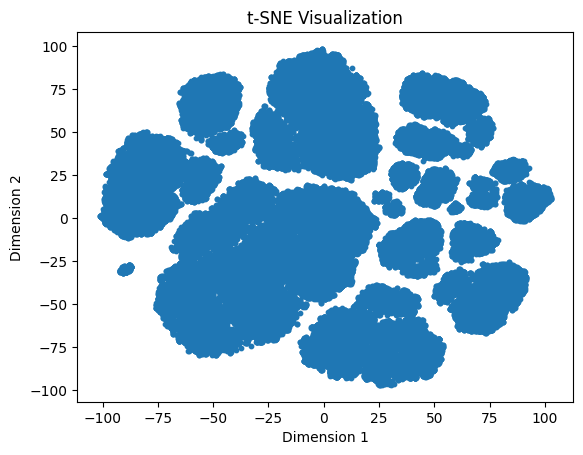

In [51]:
import matplotlib.pyplot as plt
plt.scatter(
    df_embedded[:, 0], df_embedded[:, 1], marker="o", s=10
)  # Adjust marker and size as needed
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [56]:
clustering_algo = DBSCAN(eps=2.5, min_samples=30, n_jobs=N_JOBS)
clustering_algo.fit(df_embedded)
# df["cluster"] = clustering_algo.fit_predict(df)
np.unique(clustering_algo.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19], dtype=int64),
 array([   39,  9845,  6703,  1409,  1737,  3521, 20044,  6604,  2781,
         1250,  1139,   611,  1218,  2612,  3830,   656,   446,   177,
          418,   671,    85], dtype=int64))

Visualise clusters in lower dimensions

In [58]:
pd.DataFrame(df_embedded, columns=['dim_1', 'dim_2'])

,dim_1,dim_2
0,-9.940821,63.266369
1,-71.427437,42.251961
2,89.879501,-1.468875
3,41.580769,53.836239
4,43.526409,61.365803
...,...,...
65791,-50.599144,-75.093765
65792,70.301003,-34.042034
65793,0.181037,45.407112
65794,63.307938,-50.683418


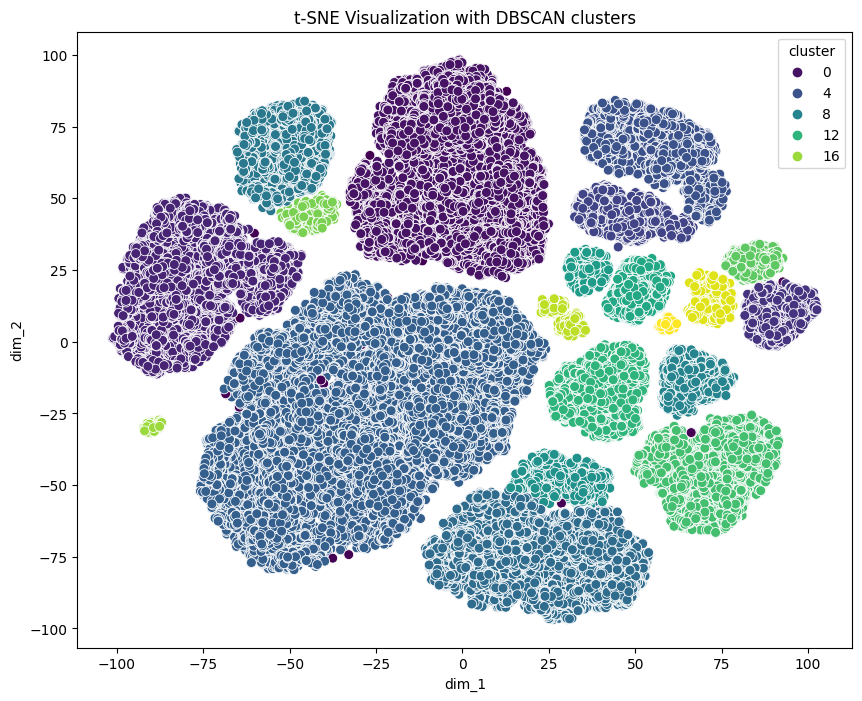

In [59]:
import seaborn as sns

data_plot = pd.DataFrame(df_embedded, columns=["dim_1", "dim_2"])
data_plot["cluster"] = clustering_algo.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="dim_1",
    y="dim_2",
    hue="cluster",
    palette="viridis",
    data=data_plot,
    s=50,
)
plt.title("t-SNE Visualization with DBSCAN clusters")
plt.show()

# Explaining clusters

In [52]:
df["cluster"] = clustering_algo.labels_

In [55]:
df.head()

,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher,Purchase_DATE_year,Purchase_DATE_month,Purchase_DATE_day,Purchase_DATE_day_of_year,Purchase_DATE_week_of_year,Purchase_DATE_is_weekend,Purchase_DATE_quarter,cluster
0,-1.732024,0.969762,-1.429241,1.175702,-0.994074,0.676254,-0.285273,1.029669,-0.633215,-0.421775,-0.577748,-0.051936,-0.152487,0.713479,-1.000002,-0.112099,-0.629445,-0.456596,0
1,-1.731972,-1.561818,0.699672,0.566671,-0.495160,-0.988170,0.638984,0.205428,-0.633215,-0.421775,1.730858,-0.051936,1.007233,-0.422043,-1.000002,0.949726,-0.629445,1.336380,0
2,-1.731919,0.897431,0.699672,-1.146647,-1.492988,-0.405822,-1.209529,0.583355,-0.633215,2.370931,-0.577748,-0.051936,-1.022277,-0.194939,1.504857,-1.107559,1.588700,-1.353084,1
3,-1.731867,-0.766179,-1.429241,1.764655,0.502667,2.064472,-0.285273,1.105254,-0.633215,2.370931,-0.577748,-0.051936,1.007233,1.054136,-1.500974,1.082454,-0.629445,1.336380,-1
4,-1.731814,-1.344825,0.699672,1.952050,-1.492988,3.094013,-0.285273,0.021864,-0.633215,2.370931,-0.577748,-0.051936,0.717303,-0.194939,-1.000002,0.684270,-0.629445,0.439892,-1


In [54]:
import warnings
warnings.filterwarnings("ignore")
i_cluster = 0
for i_cluster in range(df["cluster"].max()):
    X_train = df.drop("cluster", axis=1)
    y_train = (df["cluster"] == i_cluster) * 1
    skope_rules_clf = SkopeRules(
        feature_names=df.columns,
        random_state=RANDOM_STATE,
        n_estimators=5,
        recall_min=0.5,
        precision_min=0.5,
        max_depth_duplication=0,
        max_samples=1.0,
        max_depth=3,
    )
    skope_rules_clf.fit(X_train, y_train)
    print("Cluster " + str(i_cluster) + ":")
    print(skope_rules_clf.rules_)

Cluster 0:
[('Purchase_DATE_week_of_year <= 1.7129130363464355 and Browser <= 1.8758196830749512 and Newsletter <= 0.9745779633522034', (0.9883624440891335, 0.9090638321636665, 10))]
Cluster 1:
[('Voucher <= 0.576555073261261 and Browser <= 1.8758196830749512 and Newsletter > 0.9745779633522034', (0.8079914595089218, 0.884474123539232, 10))]
Cluster 2:
[]
Cluster 3:
[]


In [ ]:
# df.describe to check the statistics of each cluster

DiCE for recommendations on how we can turn a customer from cluster A which is low revenue to Cluster B which is high revenue. Also shows the robustness of our model etc. etc.